# LT5-LE7 Normalized SR Reflectance: NDVI & LSMA

When the Los Angeles study area was added, it became apparent that in similarly arid regions, it may be impossible to find dark rectification targets that have very low greenness. I wanted to keep a very low greenness threshold for bright targets and for both bright and dark targets in different study areas. Therefore, the rectification functions `get_hall_rectification()` and `rectification_reference_means()` both have a `hotfix` option; when `hotfix=True`, the 50th percentile of greenness will be used as the threshold below which dark targets are acceptable. Otherwise, the 20th percentile is used, as it is for bright targets regardless.

- For Los Angeles, Wet Season: `var_threshold = 60000; HOTFIX = True`
- For Los Angeles, Dry Season: `var_threshold = 40000; HOTFIX = True`

In [1]:
import ee
from IPython.display import Image
# Example iamge display:
# image = ee.Image('srtm90_v4')
# Image(url=image.getThumbUrl({'min':0, 'max': 3000}))

ee.Initialize()

# Water mask
water = ee.Image(1).where(ee.Image('JRC/GSW1_0/GlobalSurfaceWater').select('max_extent'), ee.Image(0))

## Study Area Selection

### Detroit

In [2]:
# Detroit MSA bounds
detroit_msa = ee.FeatureCollection('ft:1QZFRMLeORVfc9sYNOOKD2WyOlEyI8gmj-g3CdTlH', 'geometry')
detroit_metro = detroit_msa.filter(ee.Filter.inList('name', 
    ee.List(['Wayne', 'Oakland', 'Macomb']))) # Smaller area for sampling

# No other way, apparently, to get a range as a list; can't map type coercion client-side...
lt5_dates = ee.List([
    '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
    '2007', '2008', '2009', '2010', '2011'
])

# Not sure why I didn't originally include 1999 and 2000 in this list
le7_dates = ee.List([
    '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012',
    '2013', '2014', '2015'
])

combined_dates = ee.List([
    '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
    '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015'
])

# A common filter for selecting Landsat images
common_filter = ee.Filter([
    ee.Filter.date('1995-01-01', '2015-12-31'),
    ee.Filter.dayOfYear(121, 274),
    ee.Filter.lessThan('CLOUD_COVER_LAND', 40), # For ease of finding rectification targets
    ee.Filter.eq('WRS_PATH', 20), # NOTE: Enforcing a single path (single view angle per pixel)
])

SEASONAL_FILTER = ee.Filter.dayOfYear(121, 274)
AOI = detroit_msa
EPSG_CODE = 'EPSG:32617'

### Los Angeles

In [2]:
# Los Angeles MSA bounds
los_angeles_msa = ee.FeatureCollection('ft:1K_OAmFsUetSZapRV5ZWCsymuZeeD2g8DIP_q5ZuR', 'geometry')

# No other way, apparently, to get a range as a list; can't map type coercion client-side...
lt5_dates = ee.List([
    '1985', '1986', '1987', '1989', '1990', '1991', '1992', '1993', '1994',
    '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', 
    '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011'
])

le7_dates = ee.List([
    '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', 
    '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015'
])

combined_dates = ee.List([
    '1985', '1986', '1987', '1989', '1990', '1991', '1992', '1993', '1994',
    '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', 
    '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', 
    '2013', '2014', '2015'
])

# Wet, cool season
# SEASONAL_FILTER = ee.Filter.Or(ee.Filter.dayOfYear(1, 121), ee.Filter.dayOfYear(305, 367))
# SEASON_CODE = 'wet'

# Dry, warm season
SEASONAL_FILTER = ee.Filter.dayOfYear(121, 305)
SEASON_CODE = 'dry'

# A common filter for selecting Landsat images
common_filter = ee.Filter([
    ee.Filter.date('1985-01-01', '2015-12-31'),
    SEASONAL_FILTER,
    ee.Filter.lessThan('CLOUD_COVER_LAND', 40), # For ease of finding rectification targets
    ee.Filter.And(ee.Filter.eq('WRS_PATH', 41), ee.Filter.inList('WRS_ROW', ee.List([36, 37])))
])

AOI = los_angeles_msa
AOI_REDUCED = los_angeles_msa.filter(ee.Filter.eq('COUNTYFP', 37)) # Smaller area for sampling
EPSG_CODE = 'EPSG:26911'

## Functions

In [3]:
def annual_composite(collection, year):
    '''
    Creates an annual composite for a given year; filters to the year 
    specified, applies the cloud mask, reduces to the median value, 
    and renames the bands..
    '''
    return ee.Image(collection.filterDate(
        ee.String(year).cat(ee.String('-01-01')), 
        ee.String(year).cat(ee.String('-12-31')))\
            .map(cloud_mask)\
            .median()\
            .rename(['blue', 'green', 'red', 'NIR', 'SWIR1', 'SWIR2', 'pixel_qa'])\
            .select('blue', 'green', 'red', 'NIR', 'SWIR1', 'SWIR2')\
            .set({'year': year}))


def seasonal_composite(collection, year):
    '''
    Creates an annual composite for a given year; filters to the year 
    specified, applies the cloud mask, reduces to the median value, 
    and renames the bands..
    '''
    return ee.Image(collection.filterDate(
        ee.String(year).cat(ee.String('-01-01')), 
        ee.String(year).cat(ee.String('-12-31')))\
            .filter(SEASONAL_FILTER)\
            .map(cloud_mask)\
            .median()\
            .rename(['blue', 'green', 'red', 'NIR', 'SWIR1', 'SWIR2', 'pixel_qa'])\
            .select('blue', 'green', 'red', 'NIR', 'SWIR1', 'SWIR2')\
            .set({'year': year}))


def cloud_mask(img):
    '''
    Applies a cloud mask to an image based on the QA band of the
    Landsat data.
    '''
    # Bits 3 and 5 are cloud shadow and cloud, respectively
    cloud_shadow_bit_mask = ee.Number(2).pow(3).int()
    clouds_bit_mask = ee.Number(2).pow(5).int()
    water_mask = ee.Number(2).pow(2).int() # Bit 2 is water

    # Get the pixel QA band
    qa = img.select('pixel_qa')

    # Both flags should be set to zero, indicating clear conditions
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0)\
        .And(qa.bitwiseAnd(clouds_bit_mask).eq(0))\
        .And(qa.bitwiseAnd(water_mask).eq(0))\
        .reduceNeighborhood(ee.Reducer.anyNonZero(), ee.Kernel.square(1))
    # NOTE: Also mask those pixels that are adjacent to cloud, cloud shadow, or water

    # Return the masked image, scaled to [0, 1]
    return img.updateMask(mask).divide(10000)\
        .select(
            ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'pixel_qa'],
            ['blue', 'green', 'red', 'NIR', 'SWIR1', 'SWIR2', 'pixel_qa'])\
        .set({
            'system:time_start': img.get('system:time_start'),
            'date': ee.String(img.get('SENSING_TIME')).slice(0, 10),
            'year': ee.String(img.get('SENSING_TIME')).slice(0, 4)
        })
       
    
def dynamic_range(img, last):
    '''
    Calculates the dynamic range of an image; used as an iterator.
    '''
    names = img.bandNames()
    dr = img.clamp(0.0, 16000.0)\
        .reduceRegion(geometry = AOI, reducer = ee.Reducer.minMax(),
            scale = 30, maxPixels = 100e6)

    # Iterate over the list of band names, selecting
    #   the max and min values computed for each
    return ee.List(last).add(
        # Calculate dynamic range as max() - min()
        ee.List(names.iterate(
            lambda b, prev: ee.List(prev).add(ee.Number(dr.get(ee.String(b).cat('_').cat('max')))\
                .subtract(ee.Number(dr.get(ee.String(b).cat('_').cat('min'))))), first = ee.List([])))\
        .reduce(ee.Reducer.mean())) # Finally, calculate the mean across bands


def rescale(img):
    '''
    Converts reflectance to Landsat reflectance units: [0, 16000].
    '''
    return ee.Image(img.multiply(10e3).copyProperties(img))


def inv_rescale(img):
    '''
    Converts Landsat reflectance units to reflectance: [0, 1].
    '''
    return ee.Image(img.divide(10e3).copyProperties(img))
        

def tasseled_cap(img, b_coefs, g_coefs, w_coefs):
    '''
    Creates a Tasseled Cap-transformed image using the provided brightness,
    greenness, and wetness coefficients.
    '''
    summ = ee.call('Reducer.sum')
    brightness = img.multiply(b_coefs).reduce(summ)
    greenness = img.multiply(g_coefs).reduce(summ)
    wetness = img.multiply(w_coefs).reduce(summ)
    return brightness\
        .addBands(greenness)\
        .addBands(wetness)\
        .select([0,1,2], ['B','G','W'])
        
        
def tasseled_cap_etm_plus(img):
    '''
    Create a tasseled-cap transformation of bands using Landsat top-of-atmosphere 
    (TOA) reflectance coefficients. From Table 2:
        Liu, Q., G. Liu, C. Huang, C. Xie, L. Chu, and L. Shi. 2016. 
        Comparison of tasselled cap components of images from Landsat 5 
        Thematic Mapper and Landsat 7 Enhanced Thematic Mapper Plus. 
        Journal of Spatial Science 61 (2):351–365.
    '''
    img2 = ee.Image(img).select(['blue', 'green', 'red', 'NIR', 'SWIR1', 'SWIR2'])
    b_coefs = ee.Image([ 0.3561, 0.3972, 0.3904, 0.6966, 0.2286, 0.1596])
    g_coefs = ee.Image([-0.3344,-0.3544,-0.4556, 0.6966,-0.0242,-0.2630])
    w_coefs = ee.Image([ 0.2626, 0.2141, 0.0926, 0.0656,-0.7629,-0.5388])
    return tasseled_cap(img2, b_coefs, g_coefs, w_coefs)\
        .set({
            'year': ee.Image(img).get('year'),
            'system:time_start': ee.Image(img).get('system:time_start')
        })
        
        
def tasseled_cap_tm(img):
    '''
    Create a tasseled-cap transformation of bands using Landsat 
    surface-reflectance coefficients. From Table 1:
        Crist, E. (1985). A TM Tasseled Cap Equivalent
        Transformation for Reflectance Factor Data.
        Remote Sensing of Environment 17: 301-306
    '''
    img2 = ee.Image(img).select(['blue', 'green', 'red', 'NIR', 'SWIR1', 'SWIR2'])
    b_coefs = ee.Image([ 0.2043, 0.4158, 0.5524, 0.5741, 0.3124, 0.2303])
    g_coefs = ee.Image([-0.1603,-0.2819,-0.4934, 0.7940,-0.0002,-0.1446])
    w_coefs = ee.Image([ 0.0315, 0.2021, 0.3102, 0.1594,-0.6806,-0.6109])
    return tasseled_cap(img2, b_coefs, g_coefs, w_coefs)\
        .set({
            'year': ee.Image(img).get('year'),
            'system:time_start': ee.Image(img).get('system:time_start')
        })

### Rectification/ Normalization Functions

In [4]:
def get_hall_rectification(tc_func, hotfix=False):
    '''
    Returns a function that performs relative radiometric normalization.
    Generates rectification subject means for bright and dark targets, calculates 
    the linear transformation coefficients, then applies the rectification using 
    Hall et al.'s (1991) method. This is a longer version of 
    rectification_reference_means(), which is called for the reference image.
    '''
    dark_pct_break = 'G_p20'
    if hotfix:
        dark_pct_break = 'G_p50'
        
    def main(img):
        band_names = ee.Image(img).bandNames()
        img_tc = tc_func(img)
        img_bright = img_tc.select('B')
        img_green = img_tc.select('G')

        # Get percentiles of brightness, greenness
        pctb = img_bright.reduceRegion(geometry = AOI, 
           reducer = ee.Reducer.percentile([1, 95]), scale = 30, maxPixels = 17e6)
        pctg = img_green.reduceRegion(geometry = AOI, 
           reducer = ee.Reducer.percentile([20, 50]), scale = 30, maxPixels = 17e6)

        # NOTE: When print()ing a Dictionary, underscores are replaced with spaces!
        # Ideal rectification targets have low greenness and high (or low) brightness
        dark = ee.Image(img_bright).lt(ee.Image.constant(ee.Number(pctb.get('B_p1'))))
        bright = ee.Image(img_bright).gt(ee.Image.constant(ee.Number(pctb.get('B_p95'))))
        green = ee.Image(img_green).lt(ee.Image.constant(ee.Number(pctg.get('G_p20'))))
        potential_rect_areas = dark.addBands(bright).rename(['dark', 'bright'])

        # Mask the high-variance pixels in the Bright and Dark bands
        mask_dark = potential_rect_areas\
            .multiply(var_threshold)\
            .multiply(ee.Image(img_green\
                .lt(ee.Image.constant(ee.Number(pctg.get(dark_pct_break))))))

        # We use a different standard for Bright areas; low-green Dark areas hard to find
        mask_bright = potential_rect_areas\
            .multiply(var_threshold)\
            .multiply(ee.Image(img_green)\
                .lt(ee.Image.constant(ee.Number(pctg.get('G_p20'))))) # Should also have low greenness

        # Use this mask to mask out high-variance and non-Bright or non-Dark pixels
        sr_brights = ee.Image(img).updateMask(mask_bright.select('bright'))
        sr_darks = ee.Image(img).updateMask(mask_dark.select('dark'))

        bright_means = ee.Image(sr_brights).reduceRegion(geometry = AOI, 
           reducer = ee.Reducer.mean(), scale = 30, maxPixels = 100e6)

        dark_means = ee.Image(sr_darks).reduceRegion(geometry = AOI, 
           reducer = ee.Reducer.mean(), scale = 30, maxPixels = 100e6)

        # Create constant value images of the means in each band,
        #   allowing that some raw images have zero rectification targets
        #   in view, which means no mean could be calculated and we
        #   return null instead
        bright_sub = ee.Algorithms.If(bright_means.get('blue'),
            ee.Image(bright_means.toArray(band_names)).arrayFlatten([band_names]), # If True
            None) # If False

        dark_sub = ee.Algorithms.If(dark_means.get('blue'),
            ee.Image(dark_means.toArray(band_names)).arrayFlatten([band_names]),
            None)

        # Calculate the coefficients of the linear transformation, allowing
        #   that some raw images might have zero rectification targets in view,
        #   which means we're returning null
        m = ee.Algorithms.If(bright_sub,
            ee.Algorithms.If(dark_sub,
                bright_ref.subtract(dark_ref).divide(ee.Image(bright_sub).subtract(dark_sub)),
                None),
            None)
        b = ee.Algorithms.If(bright_sub,
            ee.Algorithms.If(dark_sub,
                dark_ref.multiply(bright_sub).subtract(ee.Image(dark_sub).multiply(bright_ref))\
                  .divide(ee.Image(bright_sub).subtract(dark_sub)),
                None),
            None)

        # Return the transformed image
        return ee.Algorithms.If(m, ee.Image(img).multiply(m).add(b), None)
    
    return main


def rectification_reference_means(hotfix = False):
    '''
    Finds rectification target means for the reference ETM+ plus image;
    used as an iterator function.
    '''
    dark_pct_break = 'G_p20'
    if hotfix:
        dark_pct_break = 'G_p50'
        
    def main(img, prev):
        img_tc = tasseled_cap_etm_plus(img)
        img_bright = img_tc.select('B')
        img_green = img_tc.select('G')

        # Get percentiles of brightness, greenness
        pctb = img_bright.reduceRegion(geometry = AOI, 
           reducer = ee.Reducer.percentile([1, 95]), scale = 30, maxPixels = 17e6)
        pctg = img_green.reduceRegion(geometry = AOI, 
           reducer = ee.Reducer.percentile([20, 50]), scale = 30, maxPixels = 17e6)

        # NOTE: When print()ing a Dictionary, underscores are replaced with spaces!
        dark = ee.Image(img_bright).lt(ee.Image.constant(ee.Number(pctb.get('B_p1'))))
        bright = ee.Image(img_bright).gt(ee.Image.constant(ee.Number(pctb.get('B_p95'))))
        potential_rect_areas = dark.addBands(bright).rename(['dark', 'bright'])

        # Mask the high-variance pixels in the Bright and Dark bands
        mask_dark = potential_rect_areas\
            .multiply(var_threshold)\
            .multiply(ee.Image(img_green\
                .lt(ee.Image.constant(ee.Number(pctg.get(dark_pct_break))))))

        # We use a different standard for Bright areas; low-green Dark areas hard to find
        mask_bright = potential_rect_areas\
            .multiply(var_threshold)\
            .multiply(ee.Image(img_green)\
                .lt(ee.Image.constant(ee.Number(pctg.get('G_p20'))))) # Should also have low greenness

        # Use this mask to mask out high-variance and non-Bright or non-Dark pixels
        sr_brights = ee.Image(img).updateMask(mask_bright.select('bright'))
        sr_darks = ee.Image(img).updateMask(mask_dark.select('dark'))

        result_bright = ee.Image(sr_brights).reduceRegion(geometry = AOI, 
           reducer = ee.Reducer.mean(), scale = 30, maxPixels = 100e6)

        result_dark = ee.Image(sr_darks).reduceRegion(geometry = AOI, 
           reducer = ee.Reducer.mean(), scale = 30, maxPixels = 100e6)

        return ee.List(prev).add(ee.List([result_bright, result_dark]))
    
    return main

### Spectral Mixture Analysis (LSMA) Functions

In [5]:
def lsma(img, ems, emv, emd):
    '''
    Constrain to be positive, sum-to-one, because these add information, 
    thereby increasing accuracy.
    '''
    return img.select('blue', 'green', 'red', 'NIR', 'SWIR1', 'SWIR2')\
        .unmix([ems, emv, emd], True, True).rename(['S', 'V', 'D'])\
        .set({'year': img.get('year')})


def svd_unmixing_etm_plus(img):
    '''
    Spectral mixture analysis using Sousa & Small's revised global
    endmembers; tables are in Supplemental Data as text files. Reference:
        Sousa, D., and C. Small. 2017. 
        Global cross-calibration of Landsat spectral mixture models. 
        Remote Sensing of Environment 192:139–149.
        
    These endmembers are for ETM+ surface reflectance data; should work 
    for TM surface reflectance data as well.
    '''
    ems = [0.218413, 0.344440, 0.535987, 0.669174, 0.754645, 0.671738]
    emv = [0.100880, 0.098638, 0.067241, 0.585458, 0.208614, 0.088058]
    emd = [0.083704, 0.047546, 0.023937, 0.010864, 0.003250, 0.002208]
    return lsma(img, ems, emv, emd)


def shade_normalize(img):
    '''
    Returns a shade-normalized fractional abundance for substrate
    and vegetation.
    '''
    substrate = img.select('S')
    vegetation = img.select('V')
    return substrate.addBands(vegetation).divide(substrate.add(vegetation))

## Assets

In [6]:
lt5_sr = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR')\
    .filter(common_filter)\
    .filterBounds(AOI)

le7_sr = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR')\
    .filter(common_filter)\
    .filterBounds(AOI)

# Water mask
water = ee.Image(1).where(ee.Image('JRC/GSW1_0/GlobalSurfaceWater').select('max_extent'), ee.Image(0))

# Look at 2013, 2013, and 2015 CDL and choose 1 where pixel is always non-cultivated, zero otherwise
# Cultivated = 2 in the "cultivated" band
cdl = ee.ImageCollection('USDA/NASS/CDL')\
    .filterBounds(AOI)\
    .filter(ee.Filter([
        ee.Filter.inList('system:index', ee.List(['2013', '2014', '2015']))
    ]))\
    .map(lambda img: img.select('cultivated').lt(2))\
    .reduce(ee.Reducer.allNonZero())\
    .clip(ee.Feature(AOI.union().toList(1).get(0)).bounds().geometry())

### Landsat Collections

In [7]:
# Individual SR scenes
lt5_sr_collection = ee.ImageCollection(lt5_sr.map(cloud_mask))
le7_sr_collection = ee.ImageCollection(le7_sr.map(cloud_mask))

### Landsat Composites

In [8]:
# The LT5 SR composite is used ONLY for selecting reference rectification targets,
#    as it has a longer record than LE7
lt5_sr_composites = ee.ImageCollection(
    lt5_dates.map(lambda year: ee.Image(seasonal_composite(lt5_sr, year))))\
    .map(rescale)

le7_sr_composites = ee.ImageCollection(
    le7_dates.map(lambda year: ee.Image(seasonal_composite(le7_sr, year))))\
    .map(rescale)

## Workspace

### Step 1: Calculating Dynamic Range

The intent here is to find the reference image (from among available SR composites) with the highest dynamic range.

In [10]:
dr_results = le7_sr_composites\
    .map(lambda img: img.updateMask(water))\
    .iterate(dynamic_range, first = ee.List([]))

print(dr_results.getInfo())

[15937.499997516474, 15950.083332175078, 14588.666628890982, 15940.833332560336, 15941.666665642211, 15943.499999741713, 15918.500001076609, 15911.000000235314, 15902.41666790098, 15883.916665179035, 14697.833318108072, 15889.416666701436, 15938.500001250455, 15920.416666233601, 15890.250000171363, 15943.249999390295, 15958.166665552804]


In [11]:
print(le7_sr_composites.iterate(lambda img, prev: ee.List(prev).add(img.get('year')), ee.List([])).getInfo())

[u'1999', u'2000', u'2001', u'2002', u'2003', u'2004', u'2005', u'2006', u'2007', u'2008', u'2009', u'2010', u'2011', u'2012', u'2013', u'2014', u'2015']


Image index 0, the 1999 image, is the one with the highest dynamic range (DR) **during the wet season** (though their cross-band means are all pretty similar). **In the dry season,** I'll use the same year, for consistency, because the DR for the 1999 image is not that different in either season.

### Step 2: Calculating Multi-Temporal Variance

In [12]:
var_map = lt5_sr_composites\
    .reduce(ee.Reducer.variance())\
    .reduce(ee.Reducer.sum())\
    .clamp(0, 1e6)

In [13]:
# Choose a variance threshold from the histogram
histogram = AOI_REDUCED.map(lambda feature: feature.set(ee.Image(var_map).reduceRegion(
    reducer = ee.Reducer.histogram(), geometry = feature.geometry(), scale = 30, maxPixels = 14e6)))

print(histogram.getInfo())

{u'type': u'FeatureCollection', u'properties': {u'DocID': u'1K_OAmFsUetSZapRV5ZWCsymuZeeD2g8DIP_q5ZuR', u'name': u'Los Angeles MSA'}, u'columns': {}, u'features': [{u'geometry': {u'type': u'Polygon', u'geodesic': True, u'coordinates': [[[-118.944502, 34.046563], [-118.94486200000001, 34.045418], [-118.938081, 34.043383], [-118.93481, 34.043507000000005], [-118.93154900000002, 34.045536], [-118.928048, 34.045847], [-118.92126899999998, 34.044475000000006], [-118.91596800000002, 34.041753], [-118.90578100000002, 34.041488], [-118.89615900000004, 34.03920699999999], [-118.895628, 34.039165000000004], [-118.88202300000002, 34.03810000000001], [-118.87485300000002, 34.037648], [-118.86249900000001, 34.03455399999999], [-118.85920500000002, 34.035309], [-118.85465299999998, 34.03421500000001], [-118.84670000000001, 34.03125699999998], [-118.84267799999999, 34.02888300000001], [-118.84037999999997, 34.027527], [-118.83682199999998, 34.024959], [-118.821958, 34.014233], [-118.821579, 34.013959

After saving the output to a file (`output.json`) and examining the histograms, below, I concluded that a variance threshold of about 30,000 seems reasonable.

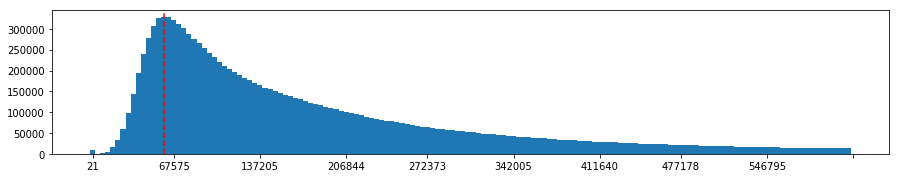

[(9913.56862745098, 21.279068081094778),
 (177.4313725490196, 6147.46115808764),
 (1156.8156862745097, 10848.356577563716),
 (5482.858823529411, 14798.259813297947),
 (15377.113725490195, 18700.966179488347),
 (32557.062745098043, 22762.238211162316),
 (59175.52549019608, 26805.423230014065),
 (97172.28627450981, 30864.689225458238),
 (144370.95294117648, 34931.05341250465),
 (193828.89019607843, 38992.001622453994),
 (238960.23529411765, 43072.99127256915),
 (279163.2313725491, 47146.32577921477),
 (307965.031372549, 51223.19415590967),
 (325613.2901960785, 55304.34483089334),
 (329046.78039215686, 59393.30554108796),
 (328389.6196078431, 63484.13585798864),
 (320511.725490196, 67575.30238994355),
 (310992.50980392157, 71670.3112447435),
 (301322.2196078432, 75759.94912206348),
 (287409.89019607846, 79854.51104990188)]

In [16]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

# with open('/home/arthur/Desktop/output.json', 'r') as stream:
#     result = eval(stream.read())
    
with open('/home/arthur/Desktop/output.pickle', 'rb') as stream:
    # Pickled using pickle.dump(massive_dict, stream, protocol = 2)
    result = pickle.load(stream)
    
plt.figure(figsize = (15, 9))
for i, feature in enumerate(result['features']):
    x_data = map(int, feature['properties']['sum']['bucketMeans'])[0:150]
    y_data = map(int, feature['properties']['sum']['histogram'])[0:150]
    plt.subplot(3, 1, i  + 1)
    plt.bar(range(0, len(y_data)), y_data, width = 1)
    idx = map(int, np.linspace(0, len(x_data), 10))
    plt.axvline(y_data.index(max(y_data)), 0, 30000, color = 'red', linestyle = 'dashed')
    plt.xticks(idx, [x for j, x in enumerate(x_data) if j in idx])

plt.show()
zip(result['features'][0]['properties']['sum']['histogram'][0:20],
    result['features'][0]['properties']['sum']['bucketMeans'][0:20])

In selecting the variance threshold, `var_threshold`, use:

- For Los Angeles, Wet Season: 60,000
- For Los Angeles, Dry Season: 40,000

In [17]:
# Filter to those pixels with variance less than the empirical threshold

var_threshold = var_map.expression('sum <= 40000', {
  'sum': var_map.select(0)
})

### Step 3: Calculate KT Transform for LT5 and Select Reference Targets

**NOTE: Whether or not a "hotfix" for selecting dark rectification targets is used should be determined in new study areas.**

In [21]:
# Get rectification target means for the reference image
ref_image = ee.ImageCollection(le7_sr_composites).toList(1).get(0)

# NOTE: hotfix = False should be tried first for better accuracy
le7_rect_target_means = ee.List([ref_image])\
    .iterate(rectification_reference_means(hotfix = True), ee.List([]))

# Ugh. This incredibly convoluted expression is here because there is easy way to convert
#    a Dictionary to a List from which to create a multi-band constant image.
bright_ref = ee.Image(ee.Dictionary(ee.List(ee.List(le7_rect_target_means).get(0)).get(0))\
        .toArray(ee.Image(le7_sr_composites.first()).bandNames()))\
    .arrayFlatten([ee.Image(le7_sr_composites.first()).bandNames()])

# NOTE: Second element (at index 1) is the dark band  
dark_ref = ee.Image(ee.Dictionary(ee.List(ee.List(le7_rect_target_means).get(0)).get(1))\
        .toArray(ee.Image(le7_sr_composites.first()).bandNames()))\
    .arrayFlatten([ee.Image(le7_sr_composites.first()).bandNames()])

**Check to see that target means are acquired; if not, use rectification_reference_means(hotfix = True)**

In [22]:
print(ee.List(le7_rect_target_means).getInfo())

[[{u'blue': 1660.4418807323395, u'SWIR1': 4039.7077177320825, u'SWIR2': 3756.16137685611, u'green': 2316.8741393503415, u'NIR': 3193.112455682168, u'red': 2827.7606842496543}, {u'blue': 411.93700399502353, u'SWIR1': 233.18129813709066, u'SWIR2': 179.60981782163634, u'green': 462.5033959180154, u'NIR': 387.4696643536259, u'red': 360.1678062262841}]]


### Step 4: Calculate the Coefficients of the Normalization, Apply, Export

In [23]:
def get_unique_dates(img, prev):
    '''
    Returns a list of unique dates from a collection of images, when
    used as an iterator function.
    '''
    date = img.get('date')
    # Get a list of *unique* dates only
    return ee.Algorithms.If(ee.List(prev).contains(date),
        ee.List(prev),
        ee.List(prev).add(date))


def normalized_median_composite(year, prev):
    # Need to convert these FeatureCollections, which actually contain Images
    #   (no idea how they ended up that way), into ImageCollections
    lt5_set = ee.Algorithms.If(ee.Algorithms.IsEqual(lt5_sr_normalized.size(), 0),
        ee.ImageCollection([]),
        ee.ImageCollection(lt5_sr_normalized.toList(lt5_sr_normalized.size()))\
            .filterMetadata('year', 'equals', year))
    
    le7_set = ee.Algorithms.If(ee.Algorithms.IsEqual(le7_sr_normalized.size(), 0),
        ee.ImageCollection([]),
        ee.ImageCollection(le7_sr_normalized.toList(le7_sr_normalized.size()))\
            .filterMetadata('year', 'equals', year))

    merged = ee.ImageCollection(ee.ImageCollection(lt5_set)\
        .merge(ee.ImageCollection(le7_set)))
    
    composite = merged\
        .median()\
        .set({
            'year': year,
            'size': ee.Number(ee.ImageCollection(lt5_set).size())\
                .add(ee.ImageCollection(le7_set).size())
    })
    
    return ee.ImageCollection(prev).merge(ee.ImageCollection([ndvi(composite)]))


def normalized_max_ndvi_first_composite(year, prev):
    # Need to convert these FeatureCollections, which actually contain Images
    #   (no idea how they ended up that way), into ImageCollections
    lt5_set = ee.Algorithms.If(ee.Algorithms.IsEqual(lt5_sr_normalized.size(), 0),
        ee.ImageCollection([]),
        ee.ImageCollection(lt5_sr_normalized.toList(lt5_sr_normalized.size()))\
            .filterMetadata('year', 'equals', year))
    
    le7_set = ee.Algorithms.If(ee.Algorithms.IsEqual(le7_sr_normalized.size(), 0),
        ee.ImageCollection([]),
        ee.ImageCollection(le7_sr_normalized.toList(le7_sr_normalized.size()))\
            .filterMetadata('year', 'equals', year))

    merged = ee.ImageCollection(ee.ImageCollection(lt5_set)\
        .merge(ee.ImageCollection(le7_set)))
    
    # Note we apply the TC transformation here *first,* before compositing
    return ee.ImageCollection(prev).merge(ee.ImageCollection([merged\
        .map(ndvi)\
        .max()\
        .set({
            'year': year,
            'size': ee.Number(ee.ImageCollection(lt5_set).size())\
                .add(ee.ImageCollection(le7_set).size())
        })
    ]))


def get_annual_vegetation_composite(lt5_sr_normalized, le7_sr_normalized, composite_stat = 'median'):
    '''
    Returns a function for creating an annual vegetation composite according to the
    requisite compositing statistic.
    '''
    def get_merged(year):
        '''
        Collects the merged, normalized collections across platforms.
        '''
        # Need to convert these FeatureCollections, which actually contain Images
        #   (no idea how they ended up that way), into ImageCollections
        lt5_set = ee.Algorithms.If(ee.Algorithms.IsEqual(lt5_sr_normalized.size(), 0),
            ee.ImageCollection([]),
            ee.ImageCollection(lt5_sr_normalized.toList(lt5_sr_normalized.size()))\
                .filterMetadata('year', 'equals', year))

        le7_set = ee.Algorithms.If(ee.Algorithms.IsEqual(le7_sr_normalized.size(), 0),
            ee.ImageCollection([]),
            ee.ImageCollection(le7_sr_normalized.toList(le7_sr_normalized.size()))\
                .filterMetadata('year', 'equals', year))

        merged = ee.ImageCollection(ee.ImageCollection(lt5_set)\
            .merge(ee.ImageCollection(le7_set)))\
            .map(inv_rescale) # NOTE: VERY IMPORTANT; coefficients are defined for reflectance
        
        return (merged, lt5_set, le7_set)
        
    
    def median_composite(year, prev):
        '''
        Creates an annual vegetation composite, given the total collection of images
        and the year in which a subset of them should be composited.
        '''
        merged, lt5_set, le7_set = get_merged(year)
        composite = merged\
            .map(lambda img: svd_unmixing_etm_plus(img))\
            .select('V')\
            .median()\
            .set({
                'year': year,
                'size': ee.Number(ee.ImageCollection(lt5_set).size())\
                    .add(ee.ImageCollection(le7_set).size())
        })

        return ee.ImageCollection(prev).merge(ee.ImageCollection([composite]))
    
    def max_composite(year, prev):
        '''
        Creates an annual vegetation composite, given the total collection of images
        and the year in which a subset of them should be composited.
        '''
        merged, lt5_set, le7_set = get_merged(year)
        composite = merged\
            .map(lambda img: svd_unmixing_etm_plus(img))\
            .select('V')\
            .max()\
            .set({
                'year': year,
                'size': ee.Number(ee.ImageCollection(lt5_set).size())\
                    .add(ee.ImageCollection(le7_set).size())
        })
        
        return ee.ImageCollection(prev).merge(ee.ImageCollection([composite]))
        
    if composite_stat == 'max':
        return max_composite
    
    return median_composite
        

def rectify_etm_plus(img):
    rectified = get_hall_rectification(tasseled_cap_etm_plus)(img)
    return ee.Algorithms.If(rectified,
        ee.Image(rectified)
            .updateMask(water)
            .set({
                'system:time_start': img.get('system:time_start'),
                'date': img.get('date'),
                'year': ee.String(img.get('date')).slice(0, 4)
            }), None)


def rectify_tm(img):
    rectified = get_hall_rectification(tasseled_cap_tm)(img)
    return ee.Algorithms.If(rectified,
        ee.Image(rectified)
            .updateMask(water)
            .set({
                'system:time_start': img.get('system:time_start'),
                'date': ee.Algorithms.If(img, img.get('date'), ''),
                'year': ee.Algorithms.If(img, ee.String(img.get('date')).slice(0, 4), '')
            }), None)


def curry_rectify_etm_plus(hotfix=False):
    '''
    Curries a variant of rectify_etm_plus() function with a hotfix, if needed.
    '''
    def rectify_etm_plus(img):
        rectified = get_hall_rectification(tasseled_cap_etm_plus, hotfix)(img)
        return ee.Algorithms.If(rectified,
            ee.Image(rectified)
                .updateMask(water)
                .set({
                    'system:time_start': img.get('system:time_start'),
                    'date': img.get('date'),
                    'year': ee.String(img.get('date')).slice(0, 4)
                }), None)

    return rectify_etm_plus


def ndvi(img):
    '''
    Calculates the normalized difference vegetation index (NDVI).
    '''
    return img.normalizedDifference(['NIR', 'red'])\
        .set({'year': img.get('year'), 'variable': 'NDVI'})

### Normalized Composite: NDVI of Median Reflectance

In [24]:
HOTFIX = True

for i in xrange(0, ee.List(combined_dates).size().getInfo()):
    year = str(list(range(1985, 2016))[i])
    
    lt5_sr_collection_minor = lt5_sr_collection\
        .filterDate( # Get just images in the given year(s)
            ee.String(year).cat(ee.String('-01-01')), 
            ee.String(year).cat(ee.String('-12-31')))\
        .select(u'blue', u'green', u'red', u'NIR', u'SWIR1', u'SWIR2')

    le7_sr_collection_minor = le7_sr_collection\
        .filterDate( # Get just images in the given year(s)
            ee.String(year).cat(ee.String('-01-01')), 
            ee.String(year).cat(ee.String('-12-31')))\
        .select(u'blue', u'green', u'red', u'NIR', u'SWIR1', u'SWIR2')

    # Get a list of the *unique* dates in these year(s)
    lt5_sr_collection_dates = lt5_sr_collection_minor\
        .iterate(get_unique_dates, ee.List([]))

    le7_sr_collection_dates = le7_sr_collection_minor\
        .iterate(get_unique_dates, ee.List([]))

    # Mosaic images from the same date in these year(s)
    lt5_sr_collection_mosaics = ee.List(lt5_sr_collection_dates)\
        .iterate(lambda date, prev: ee.ImageCollection(prev).merge(ee.ImageCollection([
            lt5_sr_collection_minor\
                .filter(ee.Filter.eq('date', ee.String(date)))\
                .median()\
                .set({'date': date})
        ])), ee.ImageCollection([]))

    le7_sr_collection_mosaics = ee.List(le7_sr_collection_dates)\
        .iterate(lambda date, prev: ee.ImageCollection(prev).merge(ee.ImageCollection([
            le7_sr_collection_minor\
                .filter(ee.Filter.eq('date', ee.String(date)))\
                .median()\
                .set({'date': date})
        ])), ee.ImageCollection([]))

    # Then, rectify each image in those year(s); 
    #   should ignore images without any unmasked rectification targets, e.g., LT05_020030_19980821
    lt5_sr_normalized = ee.ImageCollection(lt5_sr_collection_mosaics)\
        .map(rectify_tm, True) # dropNulls = true
    le7_sr_normalized = ee.ImageCollection(le7_sr_collection_mosaics)\
        .map(curry_rectify_etm_plus(HOTFIX), True) # dropNulls = true

    # DERIVATION OF NDVI PRODUCTS
    # Finally, merge the LT5 and LE7 collections in each year,
    #   then make a median pixel composite
    final_median_composites = ee.List([ee.String(year)]).iterate(normalized_median_composite, 
        ee.ImageCollection([]))
    final_max_composites = ee.List([ee.String(year)]).iterate(normalized_max_ndvi_first_composite, 
        ee.ImageCollection([]))

    # Pop off the first (N for N years) composite image(s)
    result_median = ee.Image(ee.ImageCollection(final_median_composites).toList(1).get(0))\
        .updateMask(cdl)
    result_max = ee.Image(ee.ImageCollection(final_max_composites).toList(1).get(0))\
        .updateMask(cdl)

    # Get a year for the filename/ description
    the_year = list(range(1985, 2016))[i]
    
    task = ee.batch.Export.image.toDrive(image = result_median, 
        description = 'LT5-LE7_normalized_SR_composite_median_NDVI_%s_%d' % (SEASON_CODE, the_year), 
        region = AOI.geometry().bounds().getInfo()['coordinates'],
        folder = 'EarthEngine', scale = 30, crs = EPSG_CODE)
    task.start()

    task = ee.batch.Export.image.toDrive(image = result_max, 
        description = 'LT5-LE7_normalized_SR_composite_max_NDVI_%s_%d' % (SEASON_CODE, the_year), 
        region = AOI.geometry().bounds().getInfo()['coordinates'],
        folder = 'EarthEngine', scale = 30, crs = EPSG_CODE)
    task.start()

### Normalized Composite: Fractional Vegetation Abundance

In [13]:
HOTFIX = True

for i in xrange(0, ee.List(combined_dates).size().getInfo()):
    year = str(list(range(1985, 2016))[i])
    
    lt5_sr_collection_minor = lt5_sr_collection\
        .filterDate( # Get just images in the given year(s)
            ee.String(year).cat(ee.String('-01-01')), 
            ee.String(year).cat(ee.String('-12-31')))\
        .select(u'blue', u'green', u'red', u'NIR', u'SWIR1', u'SWIR2')

    le7_sr_collection_minor = le7_sr_collection\
        .filterDate( # Get just images in the given year(s)
            ee.String(year).cat(ee.String('-01-01')), 
            ee.String(year).cat(ee.String('-12-31')))\
        .select(u'blue', u'green', u'red', u'NIR', u'SWIR1', u'SWIR2')

    # Get a list of the *unique* dates in these year(s)
    lt5_sr_collection_dates = lt5_sr_collection_minor\
        .iterate(get_unique_dates, ee.List([]))

    le7_sr_collection_dates = le7_sr_collection_minor\
        .iterate(get_unique_dates, ee.List([]))

    # Mosaic images from the same date in these year(s)
    lt5_sr_collection_mosaics = ee.List(lt5_sr_collection_dates)\
        .iterate(lambda date, prev: ee.ImageCollection(prev).merge(ee.ImageCollection([
            lt5_sr_collection_minor\
                .filter(ee.Filter.eq('date', ee.String(date)))\
                .median()\
                .set({'date': date})
        ])), ee.ImageCollection([]))

    le7_sr_collection_mosaics = ee.List(le7_sr_collection_dates)\
        .iterate(lambda date, prev: ee.ImageCollection(prev).merge(ee.ImageCollection([
            le7_sr_collection_minor\
                .filter(ee.Filter.eq('date', ee.String(date)))\
                .median()\
                .set({'date': date})
        ])), ee.ImageCollection([]))

    # Then, rectify each image in those year(s); 
    #   should ignore images without any unmasked rectification targets, e.g., LT05_020030_19980821
    lt5_sr_normalized = ee.ImageCollection(lt5_sr_collection_mosaics)\
        .map(rectify_tm, True) # dropNulls = true
    le7_sr_normalized = ee.ImageCollection(le7_sr_collection_mosaics)\
        .map(curry_rectify_etm_plus(HOTFIX), True) # dropNulls = true

    # DERIVATION OF LSMA PRODUCTS
    # Finally, merge the LT5 and LE7 collections in each year,
    #   then make a median pixel composite
    final_median_composites = ee.List([ee.String(year)]).iterate(
        get_annual_vegetation_composite(lt5_sr_normalized, le7_sr_normalized), 
        ee.ImageCollection([]))
    final_max_composites = ee.List([ee.String(year)]).iterate(
        get_annual_vegetation_composite(lt5_sr_normalized, le7_sr_normalized, 'max'), 
        ee.ImageCollection([]))

    # Pop off the first (N for N years) composite image(s)
    result_median = ee.Image(ee.ImageCollection(final_median_composites).toList(1).get(0))\
        .updateMask(cdl)
    result_max = ee.Image(ee.ImageCollection(final_max_composites).toList(1).get(0))\
        .updateMask(cdl)
    
    # Get a year for the filename/ description
    the_year = list(range(1985, 2016))[i]
    
    task = ee.batch.Export.image.toDrive(image = result_median, 
        description = 'LT5-LE7_normalized_SR_composite_median_VegetationAbundance_%s_%d' % (SEASON_CODE, the_year), 
        region = AOI.geometry().bounds().getInfo()['coordinates'],
        folder = 'EarthEngine', scale = 30, crs = EPSG_CODE)
    task.start()
    
    task = ee.batch.Export.image.toDrive(image = result_max, 
        description = 'LT5-LE7_normalized_SR_composite_max_VegetationAbundance_%s_%d' % (SEASON_CODE, the_year), 
        region = AOI.geometry().bounds().getInfo()['coordinates'],
        folder = 'EarthEngine', scale = 30, crs = EPSG_CODE)
    task.start()